In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install langchain langchain_community sentence_transformers faiss-cpu gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/

In [ ]:
import nest_asyncio
import os
import requests
from typing import Tuple, List
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.schema import Document
import gdown

nest_asyncio.apply()

def download_files_from_google_drive(file_ids: List[str], output_dir: str) -> List[str]:
    os.makedirs(output_dir, exist_ok=True)
    filepaths = []
    for file_id in file_ids:
        url = f'https://drive.google.com/uc?id={file_id}'
        output_file = os.path.join(output_dir, f"{file_id}.txt")
        gdown.download(url, output_file, quiet=False)
        filepaths.append(output_file)
    return filepaths

def create_vector_database(filepaths: List[str], data_dir="faiss_index") -> Tuple[FAISS, HuggingFaceEmbeddings]:
    all_text = ""
    for filepath in filepaths:
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                all_text += f.read() + "\n"
        except Exception as e:
            print(f"Error reading file {filepath}: {e}")
            continue

    if not all_text:
        raise ValueError("No text content found in the provided files.")

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=256)
    chunks = text_splitter.split_text(all_text)
    documents = [Document(page_content=chunk) for chunk in chunks]
    embed_model = HuggingFaceEmbeddings(model_name="BAAI/bge-m3")
    vector_store = FAISS.from_documents(documents=documents, embedding=embed_model)

    os.makedirs(data_dir, exist_ok=True)
    vector_store.save_local(data_dir)

    return vector_store, embed_model



def main():
    file_ids = [
        "18uye_O-K8m0L8sZpHBzBKav7p9U6fZa9", "1D2K4W3A1ylZ33LGWCx3RgVDgCE9VHyAf",
        "1EO1hPbaTC1KTxpUJpS_IiPz3Et_Zqm91", "1N28l1P9VG_bq3JnfQj73d11rlUh7nQVW",
        "1NaLkmVGjDt-Bc_YqZvzq0Ih9zbUTz6j7", "1NkhE92AA5CGO-RPAcOOp9jgjLoP6zzpD",
        "1OuRem9Fh78bxAvIqV-DWiScLm-5ZFLVZ", "1PaJptcCp1MQdifYO_v0I2g99rzdQDF--",
        "1Qm0Ho-ORuOge1JFrEONG45pVWfj0MSRj", "1SSvmQXCoGCcTWE-mQi1r5ciaz9Ju74gK",
        "1SdWcqiTOssXofWXdjDmghlexa2rWGfYg", "1T5cFN2LZGnGEPOdauFabSwO1ufSq48ei",
        "1TVpSwgcX3Aij_6_QYBKQJCQFqD61Hu1R", "1UpUjznQP1uJLaX-_cRZv_6kl4R_7Bp1X",
        "1WF73nkxejw8cEXdiVijFXhmR5hx02tZ7", "1X30PPanZKpNrlijhqBLx64NowuRkBGA7",
        "1XnEqNJ8h2PhbYIxdyL2ChcLL9V-7ZSn8", "1bomeO33zA-gsyvweCjEpfgkcXu4q1iDQ",
        "1c4hfq9NIS6SCP10t-7_8fxDpD-Rah-yP", "1cVoKQo8A8N40McY3X8VbjQXbsKEaaBIK",
        "1cx8ym2m9mWrKKzFV_ZyCxSg4YTrKwrHa", "1eNpbLZXXWb6iNFeDpZCtF2uUFNAlNmsB",
        "1eOPvLnNCfldgAKL8XUJtvJuzI-tOVSTe", "1fqECeDoFn3sQgHNV494dBzOW5jqSXaeQ",
        "1g9VlasrFcVOYNqP1BfEo00X7vaeB9hCH", "1oPR8JWAICP9vlgeJtaNr6aNXh-H5Jbmp",
        "1qAY1QRPBECQMMLYW9hFyxLNFip04prYk", "1r4W7veuzC0Ud4DLsf72AJ2hkIGgVCWdq",
        "1s7hQN4HKjGxrfg3K0AsF6EjkuKvh2ZOs", "1wa2crKoPkBqSKiZMtwq0uY0WSdVu7Igb",
        "1yTOgVmzttkjIGyY-yObnhTbyn9AaxDwL"
    ]

    temp_dir = "temp_downloaded_files"
    filepaths = download_files_from_google_drive(file_ids, temp_dir)
    try:
        vector_db, embed_model = create_vector_database(filepaths)
        print(f"FAISS index created and saved to {temp_dir}")
        for filepath in filepaths:
            os.remove(filepath)
        os.rmdir(temp_dir)

    except ValueError as e:
        print(e)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

if __name__ == "__main__":
    main()

Downloading...
From: https://drive.google.com/uc?id=18uye_O-K8m0L8sZpHBzBKav7p9U6fZa9
To: /content/temp_downloaded_files/18uye_O-K8m0L8sZpHBzBKav7p9U6fZa9.txt
100%|██████████| 81.3k/81.3k [00:00<00:00, 72.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1D2K4W3A1ylZ33LGWCx3RgVDgCE9VHyAf
To: /content/temp_downloaded_files/1D2K4W3A1ylZ33LGWCx3RgVDgCE9VHyAf.txt
100%|██████████| 62.8k/62.8k [00:00<00:00, 64.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EO1hPbaTC1KTxpUJpS_IiPz3Et_Zqm91
To: /content/temp_downloaded_files/1EO1hPbaTC1KTxpUJpS_IiPz3Et_Zqm91.txt
100%|██████████| 42.9k/42.9k [00:00<00:00, 40.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1N28l1P9VG_bq3JnfQj73d11rlUh7nQVW
To: /content/temp_downloaded_files/1N28l1P9VG_bq3JnfQj73d11rlUh7nQVW.txt
100%|██████████| 49.5k/49.5k [00:00<00:00, 35.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NaLkmVGjDt-Bc_YqZvzq0Ih9zbUTz6j7
To: /content/temp_downloaded_files/1NaLkmVGjDt-Bc_YqZvzq0Ih9zbUTz6

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

FAISS index created and saved to temp_downloaded_files


In [13]:
from sentence_transformers import SentenceTransformer
import numpy as np
from IPython.display import Image, display
import requests

model = SentenceTransformer("BAAI/bge-m3")

data = {
    "7 ขั้นตอนขอสินเชื่อกับศรีสวัสดิ์ เงินสดทันใจ มั่นใจ โปร่งใส ถูกกฎหมาย": "https://www.sawad.co.th/wp-content/uploads/2024/10/452800239_896789245826573_6595247655261158306_n-819x1024.jpg",
    "ขอเพิ่มวงเงินออนไลน์": "https://scontent.fbkk22-1.fna.fbcdn.net/v/t39.30808-6/485684025_1074479108057585_2498393543053649981_n.jpg?stp=dst-jpg_p600x600_tt6&_nc_cat=100&ccb=1-7&_nc_sid=127cfc&_nc_ohc=Y2nbCAZeTOAQ7kNvgFzwZHj&_nc_oc=Adl4w0_lXic8wGbh4mJTGDa9SAYKV4gbyaABb9YUTA91oN83XBTwyFND3rAsuknuNTo&_nc_zt=23&_nc_ht=scontent.fbkk22-1.fna&_nc_gid=LjzPYT5vQ0vCbhl9x3s7Zg&oh=00_AYEgCJ8ltY-K3LxfG7gJ-EiB4MDhtkYY5cR5W1ZXTyBD4g&oe=67E85741",
    "เอกสาร": "https://scontent.fbkk8-3.fna.fbcdn.net/v/t1.6435-9/54800108_2093705750698099_1899822622393237504_n.jpg?_nc_cat=108&ccb=1-7&_nc_sid=127cfc&_nc_ohc=uEqKnMoCfDEQ7kNvgE0bb5R&_nc_oc=Adm1RVRqgGuY6tj6neULdF-OgTrtojgbMDw3BfXp0rDWSkaMsDfjOUI1rI5QdEQdOOVtTyR-J6E30fyUtHxcNxxi&_nc_zt=23&_nc_ht=scontent.fbkk8-3.fna&_nc_gid=bw16Ufkv6ba5tP9HENGI4Q&oh=00_AYFkpgYHU0BBy4f1_Pxq7YWOlx203j66QHmmZjsDNeaTCw&oe=680A52D4",
    "ประกันภัยรถยนต์" : "https://scontent.fbkk12-1.fna.fbcdn.net/v/t39.30808-6/482054273_1064505705721592_7856317568504883649_n.jpg?_nc_cat=107&ccb=1-7&_nc_sid=127cfc&_nc_ohc=caIY9h_oN60Q7kNvgHoYq8y&_nc_oc=AdlxmKF7454VGz-xYQu64nlQtCmRV6RImcrDYhhn7cw8OhZncfHw6e9sgpC48VgPvW8Yui9Dpswy0Fyyra-0BWJF&_nc_zt=23&_nc_ht=scontent.fbkk12-1.fna&_nc_gid=vq507vcbe_X0jG4Toa-YBA&oh=00_AYHB0Yrx6EBnfh84D3TNsfsLaX_Er0jFm7V3ZGHCRkhWHg&oe=67E88EE7"
}

stored_texts = list(data.keys())
stored_embeddings = model.encode(stored_texts)

def find_best_match(user_input):
    input_embedding = model.encode([user_input])[0]
    similarities = np.dot(stored_embeddings, input_embedding) / (np.linalg.norm(stored_embeddings, axis=1) * np.linalg.norm(input_embedding))
    best_index = np.argmax(similarities)
    best_match = stored_texts[best_index]
    image_url = data.get(best_match, "No relevant image found.")
    
    if image_url != "No relevant image found.":
        response = requests.get(image_url)
        display(Image(response.content))
    return image_url

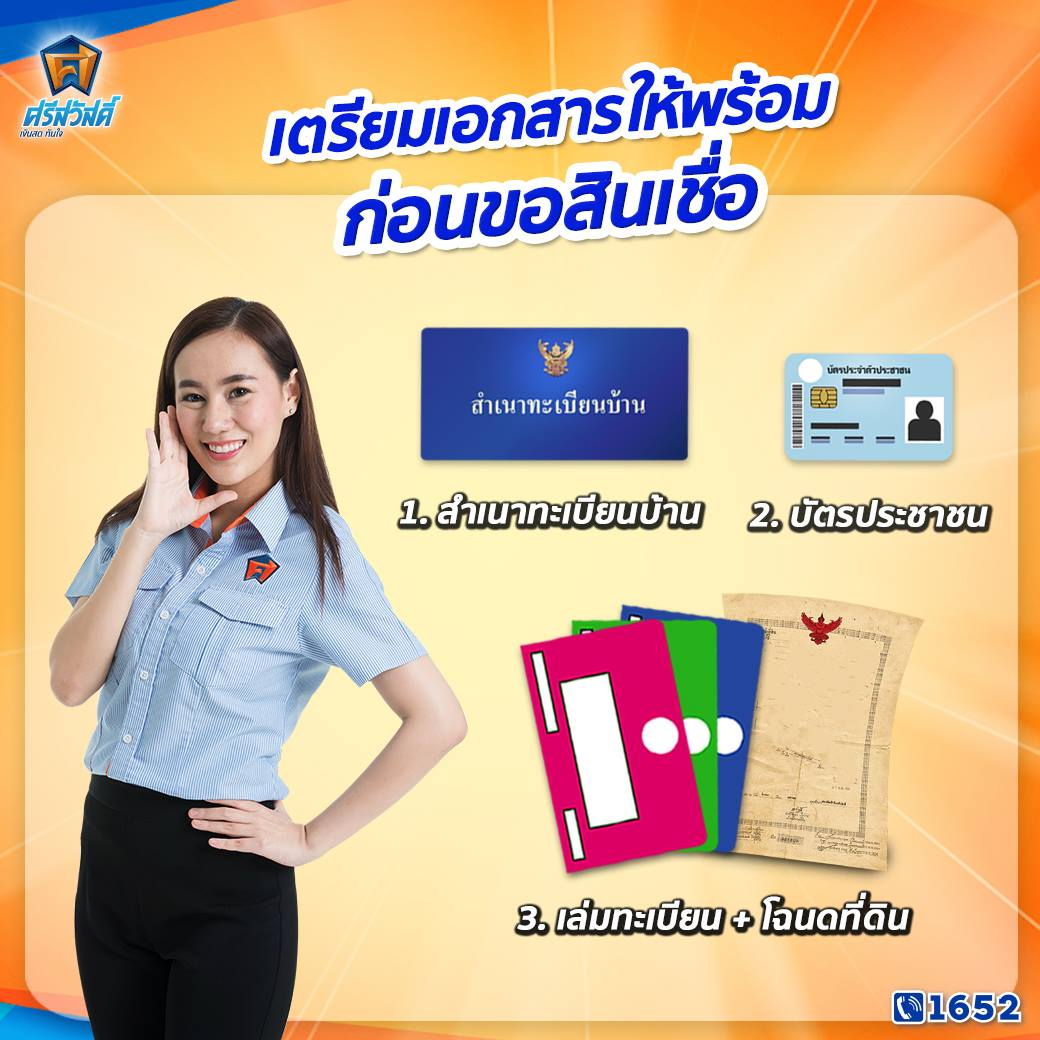

Matched Image: https://scontent.fbkk8-3.fna.fbcdn.net/v/t1.6435-9/54800108_2093705750698099_1899822622393237504_n.jpg?_nc_cat=108&ccb=1-7&_nc_sid=127cfc&_nc_ohc=uEqKnMoCfDEQ7kNvgE0bb5R&_nc_oc=Adm1RVRqgGuY6tj6neULdF-OgTrtojgbMDw3BfXp0rDWSkaMsDfjOUI1rI5QdEQdOOVtTyR-J6E30fyUtHxcNxxi&_nc_zt=23&_nc_ht=scontent.fbkk8-3.fna&_nc_gid=bw16Ufkv6ba5tP9HENGI4Q&oh=00_AYFkpgYHU0BBy4f1_Pxq7YWOlx203j66QHmmZjsDNeaTCw&oe=680A52D4


In [16]:
user_input = input("Enter your text: ")
image_url = find_best_match(user_input)
print(f"Matched Image: {image_url}")